无监督学习前言：  
由于监督学习需要有标签数据，但是绝大多数可用数据都没有标签。因此，我们先从无监督学习开始。  


无监督学习应用的场景主要有

1）降维：由于ML会涉及成千上万个特征，特征工程会机器缓慢。实际中，我们可以减少特征的数量，从而提高模型的效率

2）聚类：将相似的实例分组到集群中，聚类分析可以帮助我们发现数据中的隐藏模式和结构，应用于客群分析，推荐系统等场景 

3）异常检测：“学习”正常数据的特征，并使用它来检测异常点。比如欺诈检测等

4）密度估计：估计生成数据集的随机过程的概率密度函数

一、K-Means聚类  
它的目标是将n个观察值分成k个簇，其中每个观察值都属于具有最近平均值（簇中心或聚类质心）的簇，从而使得聚类质心尽可能远离彼此  


训练步骤：  
1）初始化：随机选择K个点作为质心  
$C={c_1,c_2,...,c_K}$  
2）分配：遍历每个样本，将其分配给距离最近的质心  
$r_{ij}=1$ if $x_i$ belongs to $c_j$ else $r_{ij}=0$  
3）更新：计算每个簇内所有点的平均值，并将质心移动到该平均位置  
$c_j=\frac{1}{|S_j|}\sum_{i\in S_j}x_i$  
4）收敛：判断当前迭代是否收敛，可定义一个阈值，当任意两次迭代的质心最大移动距离小于该阈值时认为已经收敛  
5）更新：如果没有达到收敛，则重复2-4。目标是最小化所有簇内样本点与质心的距离平方和（SSE），数学表示为   
$SSE=\sum_{j=1}^K\sum_{i\in S_j}(x_i-c_j)^2$   
该值越小说明样本越靠近自己的聚类中心，聚类效果越好

先看个动图  
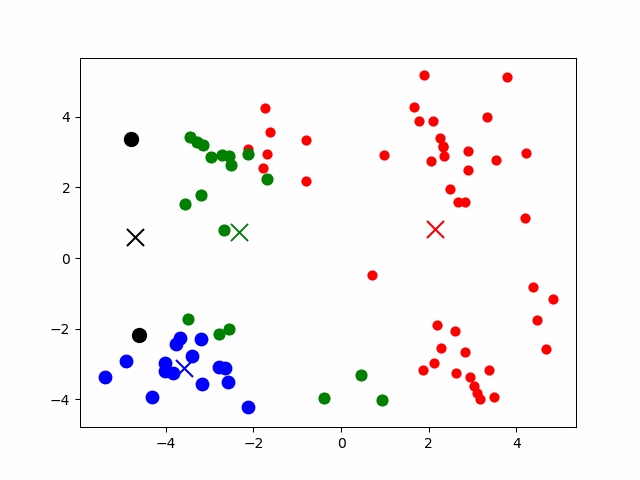

上图就展现了质心为4的K-means模型的训练过程  
我们先来手搓一遍  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

# 全局设置（解决中文乱码、统一画布大小）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (8, 6)

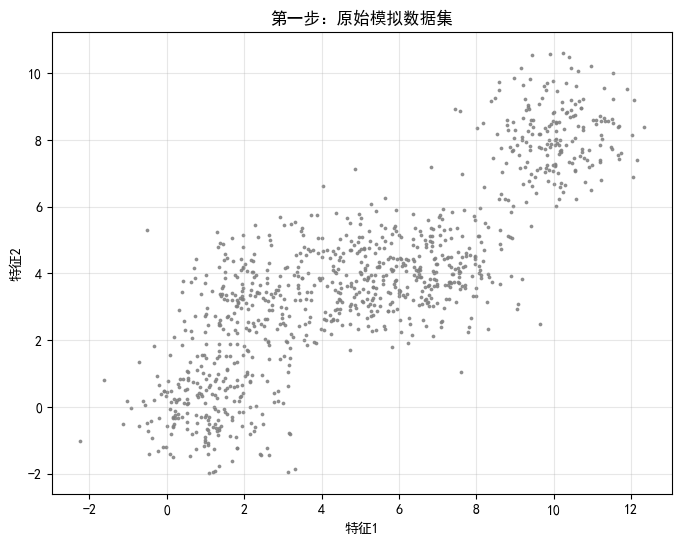

In [2]:
# 生成数据
X, y = datasets.make_blobs(n_samples=1000, n_features=2, 
                           centers=[[1,0],[5,4],[2,3],[10,8],[7,4]],
                           random_state=42)


plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c='gray', alpha=0.8)
plt.title('第一步：原始模拟数据集')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.grid(alpha=0.3)
plt.show()  

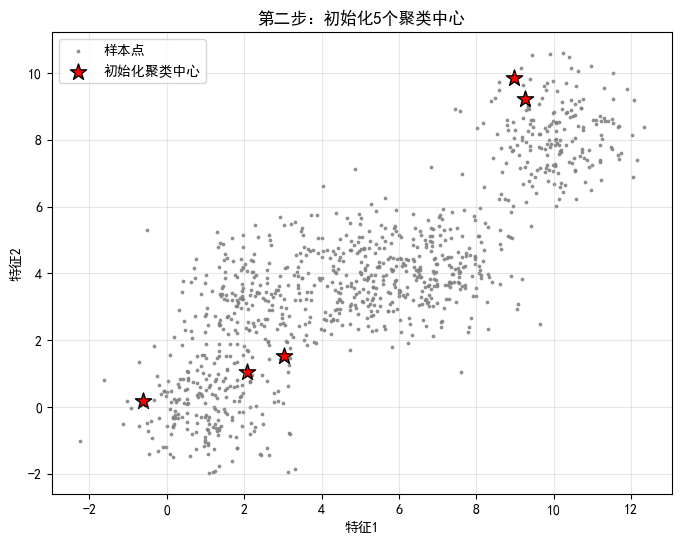

In [3]:
# 设置聚类数
k = 5

# 随机选择k个样本作为初始中心
m, n = X.shape  # m=1000（样本数），n=2（特征数）
center_ids = np.random.choice(m, k, replace=False)  # 不重复选择
centers = X[center_ids]  # 初始中心


plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c='gray', alpha=0.8, label='样本点')
plt.scatter(centers[:, 0], centers[:, 1], s=150, c='red', marker='*', 
            edgecolors='black', label='初始化聚类中心')
plt.title('第二步：初始化5个聚类中心')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(alpha=0.3)
plt.show() 

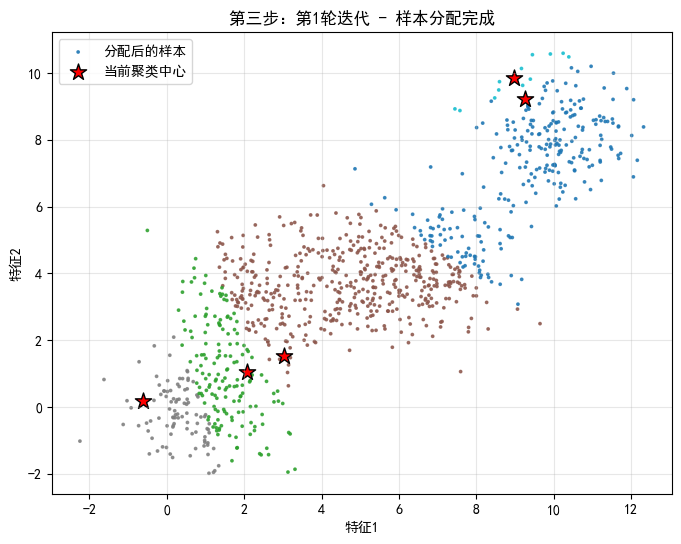

In [4]:
# 初始化样本类别标签（全为0）
pred_y = np.zeros((m,))
keep_changing = True  # 标记是否继续迭代
iteration = 0  # 迭代次数

# 第一轮迭代：样本分配
old_pred_y = pred_y.copy()  # 保存分配前的标签
for i in range(m):
    min_distance = np.inf  # 初始化最小距离为无穷大
    for center_idx in range(k):
        # 计算样本i到第center_idx个中心的欧式距离
        distance = np.linalg.norm(X[i, :] - centers[center_idx, :])
        if distance < min_distance:
            min_distance = distance
            idx = center_idx  # 记录最近的中心索引
    # 判断类别是否变化
    if pred_y[i] != idx:
        keep_changing = True
    pred_y[i] = idx  # 更新样本i的类别

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c=pred_y, cmap='tab10', alpha=0.8, label='分配后的样本')
plt.scatter(centers[:, 0], centers[:, 1], s=150, c='red', marker='*', 
            edgecolors='black', label='当前聚类中心')
plt.title(f'第三步：第{iteration+1}轮迭代 - 样本分配完成')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()  

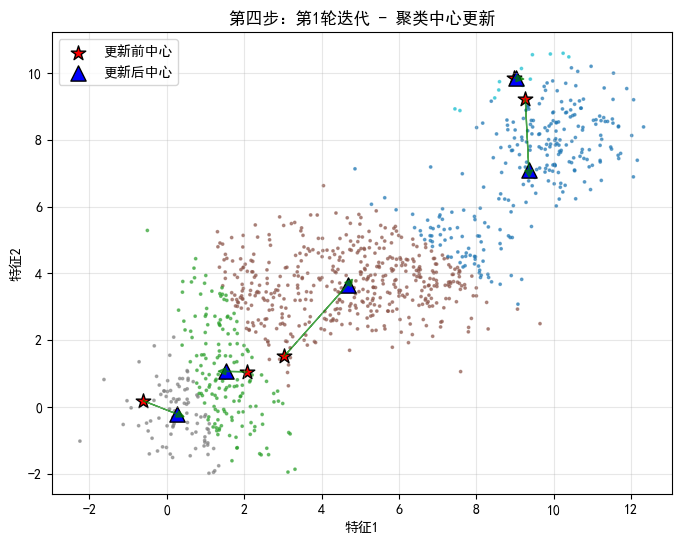

In [5]:
# 第一轮迭代：中心更新（M步）
old_centers = centers.copy()  # 保存更新前的中心
new_centers = np.zeros_like(centers)  # 初始化新中心

for center_idx in range(k):
    # 取出所有属于第center_idx类的样本
    cluster_data = X[pred_y == center_idx]
    # 计算该类样本的均值，作为新中心
    new_centers[center_idx, :] = np.mean(cluster_data, axis=0)

# 更新中心
centers = new_centers.copy()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c=pred_y, cmap='tab10', alpha=0.6)
# 更新前的中心（红色星号）
plt.scatter(old_centers[:, 0], old_centers[:, 1], s=120, c='red', marker='*', 
            edgecolors='black', label='更新前中心')
# 更新后的中心（蓝色三角形）
plt.scatter(new_centers[:, 0], new_centers[:, 1], s=120, c='blue', marker='^', 
            edgecolors='black', label='更新后中心')
# 绘制中心移动箭头
for i in range(k):
    plt.arrow(old_centers[i, 0], old_centers[i, 1],
             new_centers[i, 0] - old_centers[i, 0],
             new_centers[i, 1] - old_centers[i, 1],
             head_width=0.2, head_length=0.2, fc='green', ec='green', alpha=0.7)
plt.title(f'第四步：第{iteration+1}轮迭代 - 聚类中心更新')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()  

# 迭代次数+1
iteration += 1

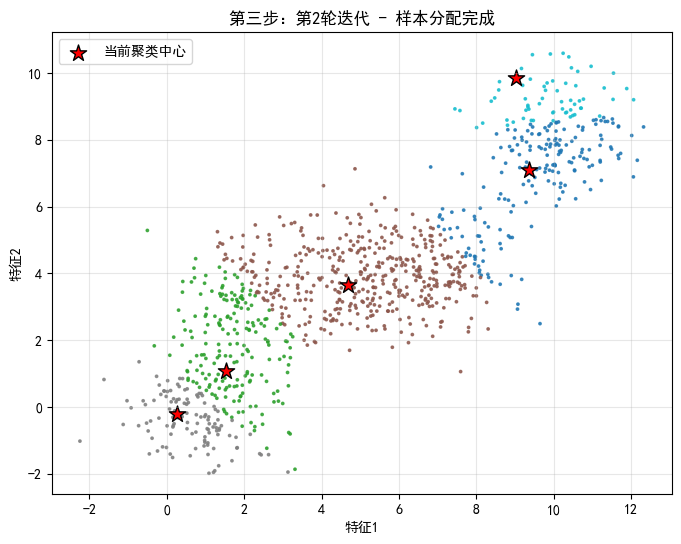

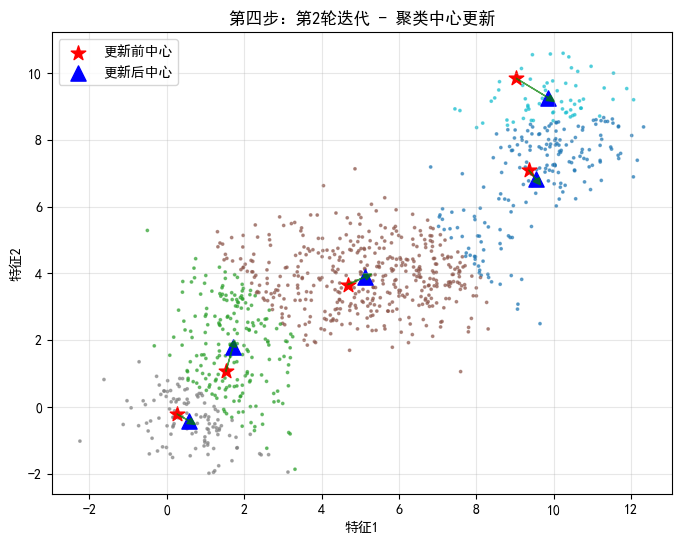

第二轮迭代后，是否需要继续迭代：True


In [6]:
# 第二轮迭代：样本分配（E步）
old_pred_y = pred_y.copy()
keep_changing = False  # 重置标记
for i in range(m):
    min_distance = np.inf
    for center_idx in range(k):
        distance = np.linalg.norm(X[i, :] - centers[center_idx, :])
        if distance < min_distance:
            min_distance = distance
            idx = center_idx
    if pred_y[i] != idx:
        keep_changing = True
    pred_y[i] = idx

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c=pred_y, cmap='tab10', alpha=0.8)
plt.scatter(centers[:, 0], centers[:, 1], s=150, c='red', marker='*', 
            edgecolors='black', label='当前聚类中心')
plt.title(f'第三步：第{iteration+1}轮迭代 - 样本分配完成')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 第二轮迭代：中心更新（M步）
old_centers = centers.copy()
new_centers = np.zeros_like(centers)
for center_idx in range(k):
    cluster_data = X[pred_y == center_idx]
    new_centers[center_idx, :] = np.mean(cluster_data, axis=0)
centers = new_centers.copy()

# 可视化：第二轮中心更新
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c=pred_y, cmap='tab10', alpha=0.6)
plt.scatter(old_centers[:, 0], old_centers[:, 1], s=120, c='red', marker='*', label='更新前中心')
plt.scatter(new_centers[:, 0], new_centers[:, 1], s=120, c='blue', marker='^', label='更新后中心')
for i in range(k):
    plt.arrow(old_centers[i, 0], old_centers[i, 1],
             new_centers[i, 0] - old_centers[i, 0],
             new_centers[i, 1] - old_centers[i, 1],
             head_width=0.2, head_length=0.2, fc='green', ec='green', alpha=0.7)
plt.title(f'第四步：第{iteration+1}轮迭代 - 聚类中心更新')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

iteration += 1
# 查看是否收敛（keep_changing=False 则收敛）
print(f"第二轮迭代后，是否需要继续迭代：{keep_changing}")

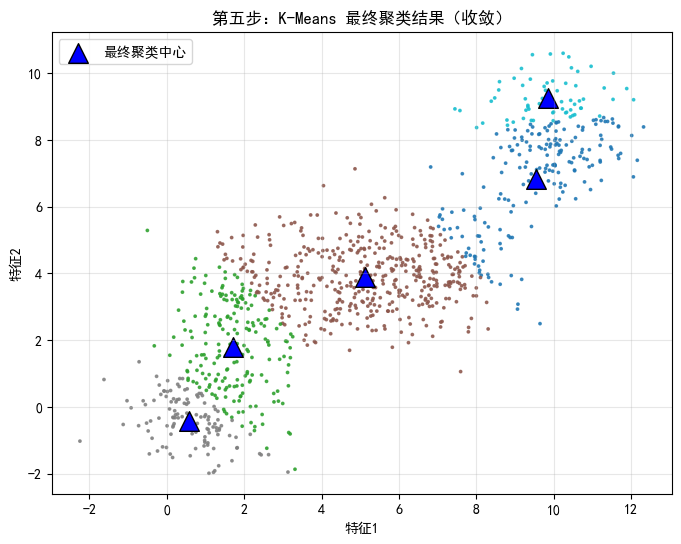

最终聚类中心：
[[ 9.54531663  6.81965492]
 [ 1.71009844  1.80743995]
 [ 5.118179    3.89749858]
 [ 0.57378047 -0.41627615]
 [ 9.85598941  9.2680664 ]]


In [7]:
# 可视化最终结果
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=3, c=pred_y, cmap='tab10', alpha=0.8)
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='blue', marker='^', 
            edgecolors='black', label='最终聚类中心')
plt.title('第五步：K-Means 最终聚类结果（收敛）')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("最终聚类中心：")
print(centers)

上述步骤是对K-Means算法的一个完整迭代过程，包括样本分配（E步）和中心更新（M步）  
该示例有2个特征，5个聚类中心  

接下来，我们用Sklearn中的KMeans类来实现K-Means算法

采用的数据集为鸢尾花数据集合  
给数据集合有150个样本  
三类鸢尾花：① 山鸢尾（Iris-setosa）② 变色鸢尾（Iris-versicolor）③ 维吉尼亚鸢尾（Iris-virginica）  
每类样本数：50个  
特征数包含四个连续性的特征：① 萼片长度（sepal length）② 萼片宽度（sepal width）③ 花瓣长度（petal length）④ 花瓣宽度（petal width）  


由于我们知道了鸢尾花有三类因此最初的聚类中心数即为3

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)

In [9]:
iris=load_iris()

x=iris.data
y=iris.target
feature_names=iris.feature_names  
target_names=iris.target_names

df=pd.DataFrame(x,columns=feature_names)
df['target']=y 
df['真实类别'] = [target_names[i] for i in y]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,真实类别
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [10]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(x)


In [11]:
k=3 #设置初始聚类数
random_state=42
kmeans=KMeans(n_clusters=k,random_state=random_state)
kmeans.fit(X_scaled)

cluster_labels = kmeans.labels_  # 聚类预测标签
cluster_centers = kmeans.cluster_centers_  # 聚类中心（标准化后）
inertia = kmeans.inertia_  # 总惯性（SSE）
n_iter = kmeans.n_iter_  # 实际迭代次数

# 打印模型核心结果
print("\n=== K-Means模型训练结果 ===")
print(f"聚类预测标签（前10个）：{cluster_labels[:10]}")
print(f"聚类中心（标准化后）：\n{np.round(cluster_centers, 2)}")
print(f"总惯性（SSE）：{np.round(inertia, 2)}")
print(f"模型实际迭代次数：{n_iter}")
print(f"轮廓系数（聚类效果）：{np.round(silhouette_score(X_scaled, cluster_labels), 3)}")



=== K-Means模型训练结果 ===
聚类预测标签（前10个）：[1 2 2 2 1 1 1 1 2 2]
聚类中心（标准化后）：
[[ 0.57 -0.37  0.69  0.66]
 [-0.82  1.32 -1.29 -1.22]
 [-1.33 -0.37 -1.14 -1.11]]
总惯性（SSE）：191.02
模型实际迭代次数：4
轮廓系数（聚类效果）：0.48


由于K=3是我们预先知道有三类，那么这个3到底是不是合理的呢，进行验证  


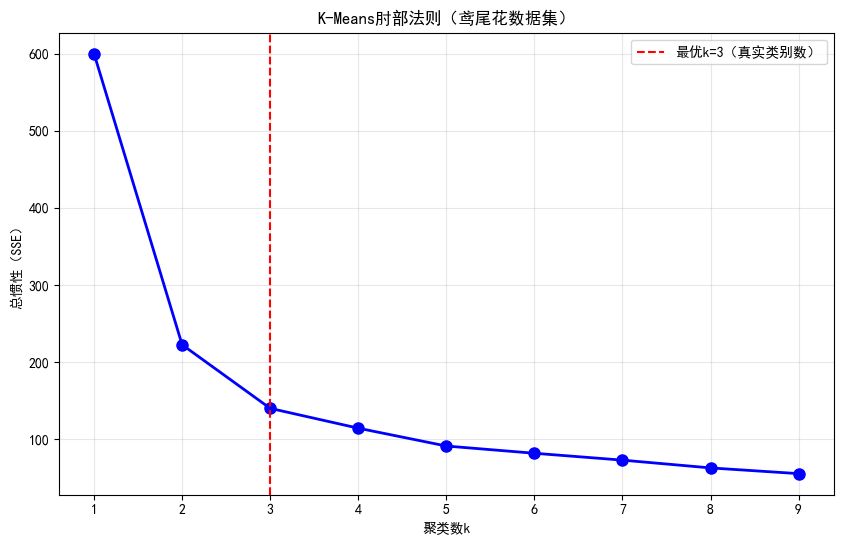

In [14]:
sse = []
k_range = range(1, 10)
for k_test in k_range:
    kmeans_test = KMeans(n_clusters=k_test, random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    sse.append(kmeans_test.inertia_)

# 可视化肘部法则图
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linewidth=2, markersize=8, color='blue')
plt.axvline(x=3, color='red', linestyle='--', label='最优k=3（真实类别数）')
plt.title('K-Means肘部法则（鸢尾花数据集）')
plt.xlabel('聚类数k')
plt.ylabel('总惯性（SSE）')
plt.xticks(k_range)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

这种方法叫肘部法则  
SSE随着K的增加必然单调递减，但递减速度会有明显变化：  

1）当K较小时，K每增加1，SSE会大幅下降  

2）达到最优时：K就增加，SSE的下降速度会变缓  

3）下降速度突变的点，即为最优K。既可以保证聚类紧凑，有避免K过大导致过拟合

该数据集是因为我们知道有三类，那么我们不知道有多少个类别的数据有应该如何呢？  


我们利用kaggle平台的客户分类数据集  

数据集的数据包括 客户ID,  性别， 客户年龄， 客户年收入， 客户的消费习惯。

1. 客户ID: 代表唯一标识客户的整数；

2. 客户的性别： 区分男客户和女客户， 使得相关数据更加的完整；

3. 客户的年龄： 客户的出生年份，表示客户的年龄；

4. 客户的年收入： 客户的年度收入， 表示客户的消费能力；

5. 客户的消费习惯： 客户的购买行为和偏好， 包括所购买商品的类别，购买次数，购买金额。

In [15]:
#导入所需库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
import plotly as py
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [16]:
df=pd.read_csv(r'Unsupervised Learning\Clustering\lecture 4 K-means\Segmentation_dataset.csv')
df.head()
df_original = df.copy()

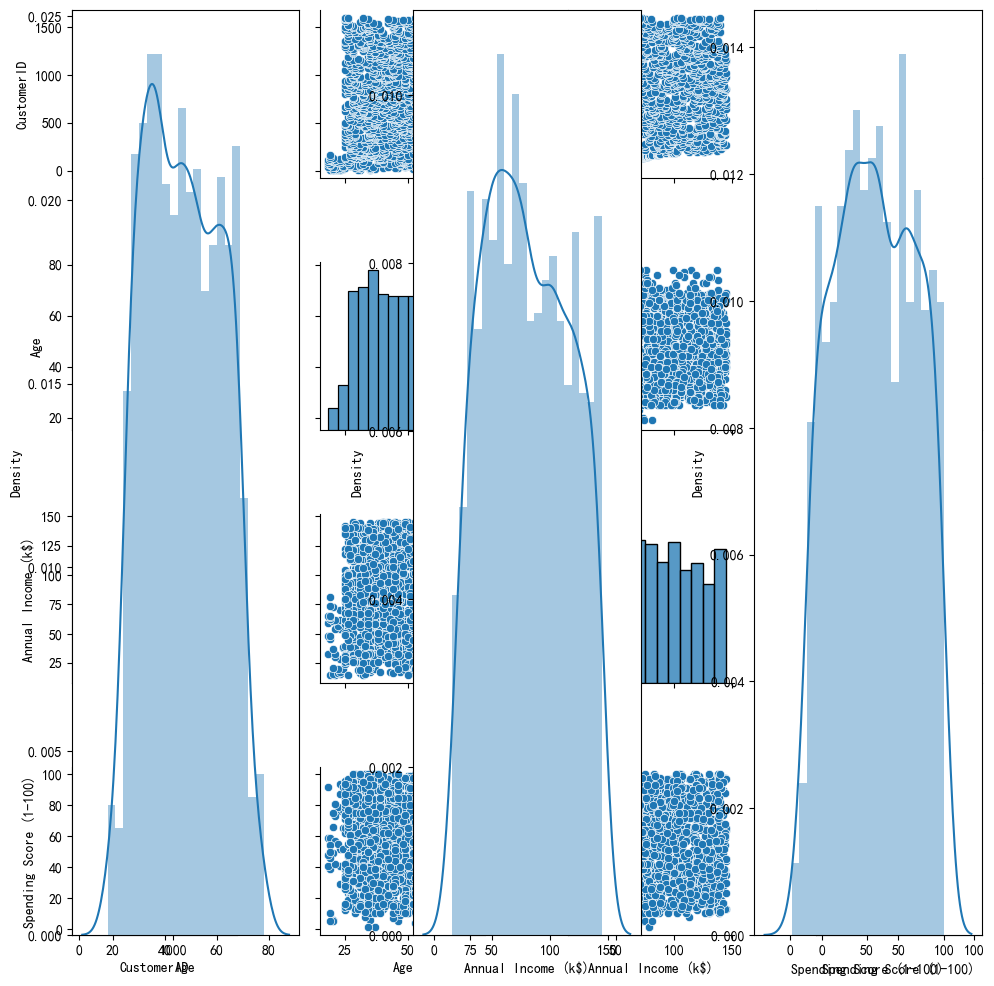

In [17]:
sns.pairplot(df)
plt.figure(1,figsize=(12,6))
n=0
for x in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df[x],bins=20)
plt.show()

 每一个柱状图显示出了不同年龄段的人口密度，第二个柱状图显示了不同年龄段的之处得分，第三个柱状图显示了不同年龄段的平均收入，从图中可以看出，随着年龄的增长，人口密度逐渐减少，而之处得分与平均年收入呈现不同的趋势

再来看看性别比例

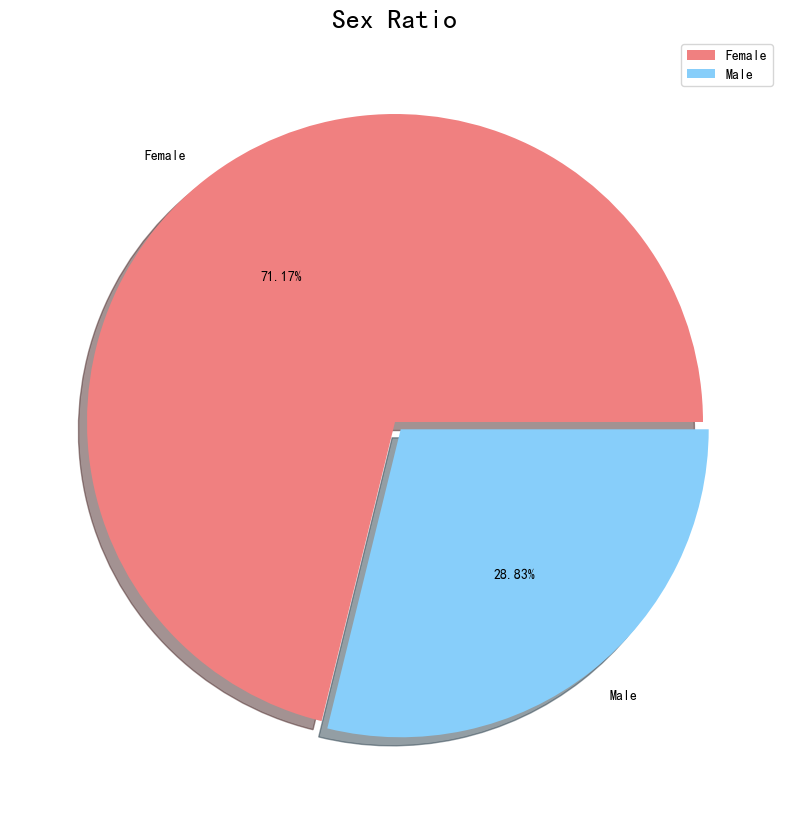

In [18]:
#样本数据中的性别比
#计算每个性别的数量
df_gender_c = df['Gender'].value_counts()
#定义了标签、颜色等
p_lables = ['Female', 'Male']
p_color = ['lightcoral', 'lightskyblue']
p_explode = [0, 0.03]
# 绘图
#创建一个10x10的图形窗口
plt.figure(1,figsize=(10,10))
plt.pie(df_gender_c, labels=p_lables, colors=p_color, explode=p_explode, shadow=True, autopct='%.2f%%')
plt.title('Sex Ratio',fontsize=20)
plt.axis('off')
plt.legend(fontsize=14)
plt.legend()
plt.show()

即女性多于男性

看看年龄与年收入的关系

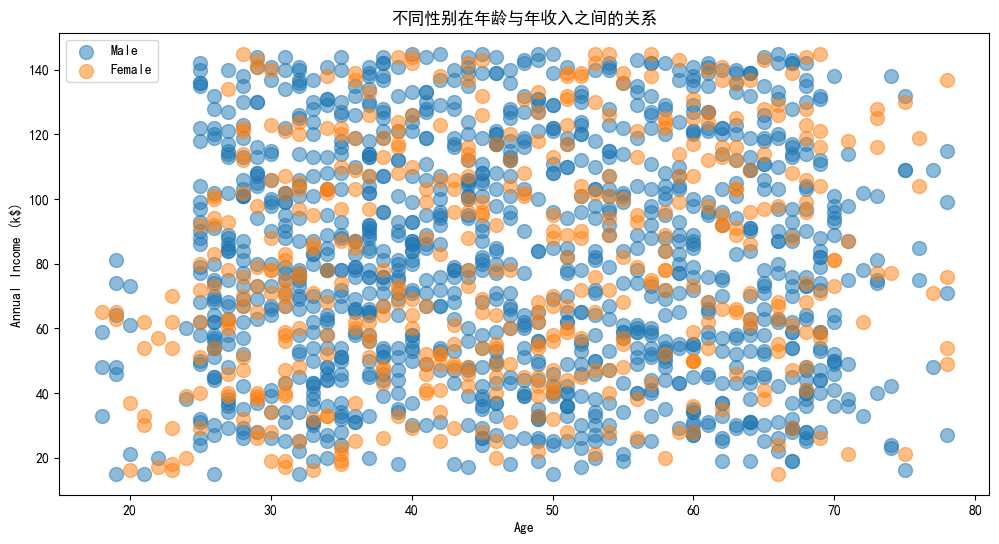

In [19]:

plt.figure(1,figsize=(12,6))
# 遍历性别列表，分别绘制男性和女性的散点图
for gender in ['Male','Female']:
    # 使用scatter函数绘制散点图，x轴为年龄，y轴为年收入，数据来源为df中性别为当前性别的数据
    plt.scatter(x='Age',y='Annual Income (k$)',data=df[df['Gender']==gender],
               s=100,alpha=0.5,label=gender)
# 设置x轴标签为“Age”，y轴标签为“Annual Income (k$)”
plt.xlabel('Age'),plt.ylabel('Annual Income (k$)')
# 设置图形标题为“不同性别在年龄与年收入之间的关系”
plt.title('不同性别在年龄与年收入之间的关系')
# 显示图例
plt.legend()
# 显示图形
plt.show()

从图中可以看出，不同的性别在年龄与年收入之间存在差异，这就意味着不同性别在相同的年龄段年收入水平存在差异，不同性别在不同的年龄段存在差异 

年龄与消费,与年收入之间的分布

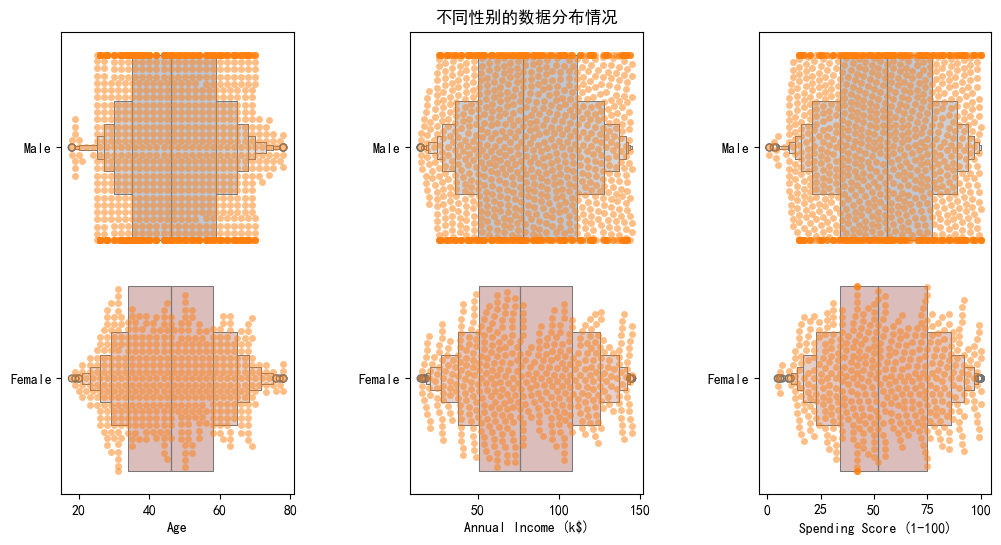

In [20]:
# 创建一个1行3列的图形，大小为12x6英寸
plt.figure(1,figsize=(12,6))
# 初始化计数器n
n=0
# 遍历三个类别（年龄、年收入和消费得分）
for cloname in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.boxenplot(x=cloname,y='Gender',data=df,palette='vlag')
    sns.swarmplot(x=cloname,y='Gender',data=df,alpha=0.5)
    plt.ylabel('' if n==1 else '')
    plt.title('不同性别的数据分布情况' if n==2 else '')
# 显示图形
plt.show()

这张图展示了不同性别在年龄，年收入和之处得分之间的变化情况，从图中可以看出，男性在相关指标上分布较为集中，二女性则呈现分散的趋势，可以移位这男性在这些方面表现的相对稳定，二女性则存在一定的波动

In [21]:
#数据清洗
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1}) 
from sklearn.preprocessing import LabelEncoder#标准化
S_columns=df.iloc[:,2:5]
scaler=StandardScaler()
S_columns=scaler.fit_transform(S_columns)
df.iloc[:,2:5]=S_columns
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,-1.967495,-1.834367,-0.622794
1,2,0,-1.826683,-1.834367,1.020455
2,3,1,-1.897089,-1.806273,-1.913919
3,4,1,-1.685871,-1.806273,0.863955
4,5,1,-1.122622,-1.778178,-0.583669


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
features=df.drop(columns=['CustomerID'])
features.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,-1.967495,-1.834367,-0.622794
1,0,-1.826683,-1.834367,1.020455
2,1,-1.897089,-1.806273,-1.913919
3,1,-1.685871,-1.806273,0.863955
4,1,-1.122622,-1.778178,-0.583669


K=2 时，轮廓系数：0.2240
K=3 时，轮廓系数：0.2296
K=4 时，轮廓系数：0.2548
K=5 时，轮廓系数：0.2459
K=6 时，轮廓系数：0.2464
K=7 时，轮廓系数：0.2363
K=8 时，轮廓系数：0.2293
K=9 时，轮廓系数：0.2230
K=10 时，轮廓系数：0.2230


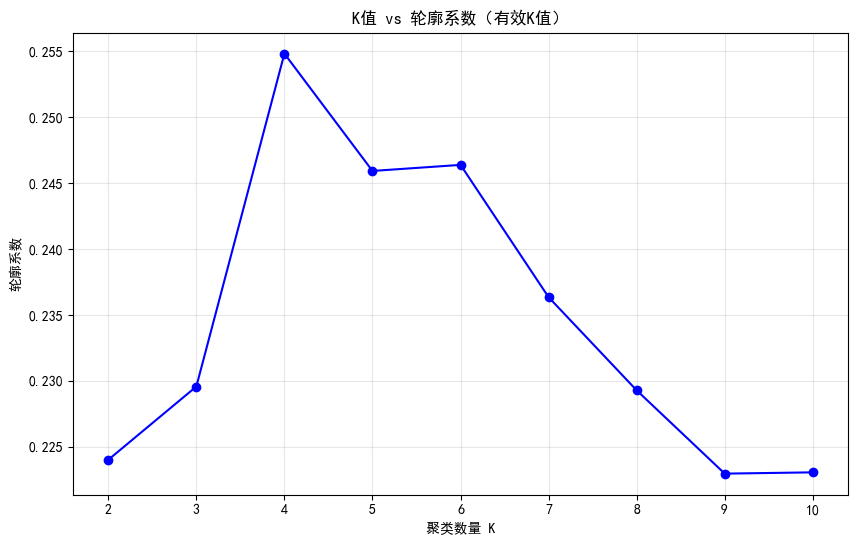


最优聚类数量K为：4

各聚类的样本数量：
Cluster
3    454
1    394
0    380
2    371
Name: count, dtype: int64


In [25]:
k_range = range(2, min(11, len(df)))  # K最大不超过样本数（避免K>样本数）
silhouette_scores = []
valid_k = []  # 存储有效K值
for k in k_range:
    if len(df) <= k:
        print(f"跳过K={k}：样本数({len(df)}) ≤ K值({k})")
        continue
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)
    
    unique_labels = np.unique(cluster_labels)
    if len(unique_labels) < 2:
        print(f"跳过K={k}：所有样本被聚为1类，无法计算轮廓系数")
        continue
    
    # 计算轮廓系数
    score = silhouette_score(features, cluster_labels)
    silhouette_scores.append(score)
    valid_k.append(k)
    print(f"K={k} 时，轮廓系数：{score:.4f}")

# 确定最优K并执行最终聚类
if len(silhouette_scores) == 0:
    print("\n无有效K值")
else:
    # 可视化有效K值的轮廓系数
    plt.figure(figsize=(10, 6))
    plt.plot(valid_k, silhouette_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('聚类数量 K')
    plt.ylabel('轮廓系数')
    plt.title('K值 vs 轮廓系数（有效K值）')
    plt.xticks(valid_k)
    plt.grid(True, alpha=0.3)
    plt.show()

    # 最优K
    optimal_k = valid_k[np.argmax(silhouette_scores)]
    print(f"\n最优聚类数量K为：{optimal_k}")

    # 最终聚类
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['Cluster'] = final_kmeans.fit_predict(features)
    
    # 输出聚类结果
    print("\n各聚类的样本数量：")
    cluster_counts = df['Cluster'].value_counts()
    print(cluster_counts)


各聚类类别特征解读：

【聚类 0】
   - 样本数量：380 个（占比：23.8%）
   - 性别分布：女性占比 27.4%，男性占比 72.6%
   - 年龄特征：平均 0.5 岁（范围：-1.545058843064123-2.186463008550446 岁）
   - 年收入特征：平均 0.8k$（范围：-1.0196258560731408-1.8179216372056737k$）
   - 消费得分特征：平均 0.9 分（范围：-0.661919338553618-1.7638295667224642 分）

【聚类 1】
   - 样本数量：394 个（占比：24.6%）
   - 性别分布：女性占比 28.4%，男性占比 71.6%
   - 年龄特征：平均 0.8 岁（范围：-0.840998116344393-2.186463008550446 岁）
   - 年收入特征：平均 -0.8k$（范围：-1.8343672155294342-0.9750857481129565k$）
   - 消费得分特征：平均 -0.5 分（范围：-2.0312937205643093-1.4508297079771633 分）

【聚类 2】
   - 样本数量：371 个（占比：23.2%）
   - 性别分布：女性占比 27.2%，男性占比 72.8%
   - 年龄特征：平均 -0.3 岁（范围：-1.967495279095961-2.0456508632065 岁）
   - 年收入特征：平均 0.8k$（范围：-0.7948696189817497-1.8179216372056737k$）
   - 消费得分特征：平均 -1.0 分（范围：-2.109543685250635-0.31620522002544743 分）

【聚类 3】
   - 样本数量：454 个（占比：28.4%）
   - 性别分布：女性占比 31.7%，男性占比 68.3%
   - 年龄特征：平均 -0.9 岁（范围：-2.037901351767934-0.7079354824390129 岁）
   - 年收入特征：平均 -0.6k$（范围：-1.8343672155294342-0.9469912184765326k$）
   - 消费得分特征：平均

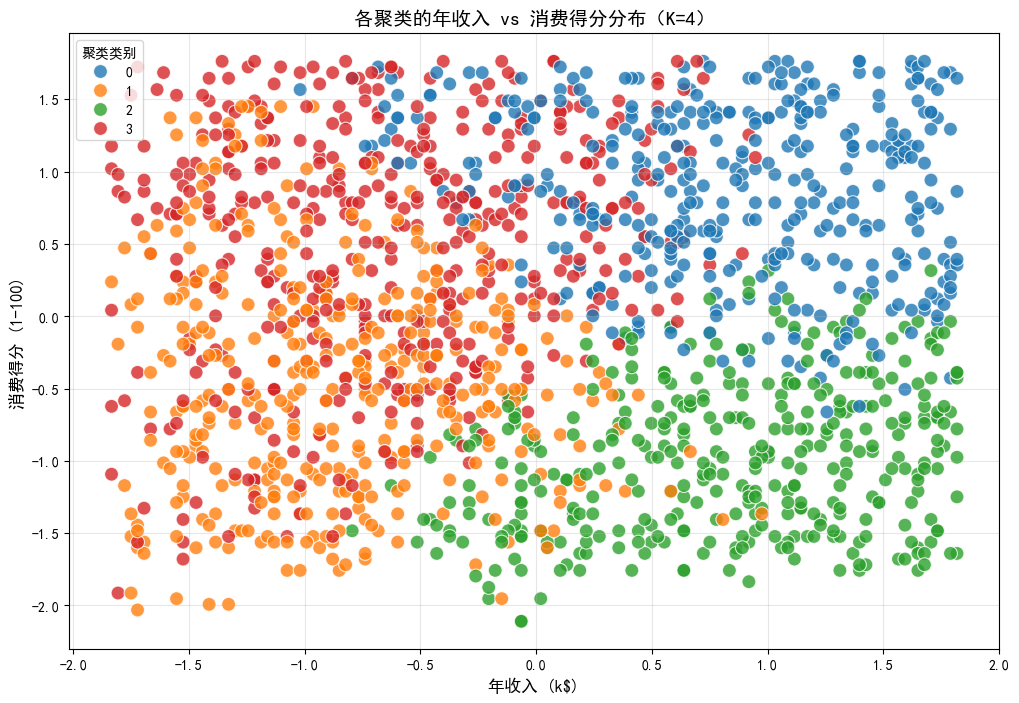

In [29]:
def describe_clusters(df, cluster_counts, optimal_k):
    """
    对K-means聚类结果进行详细的类别描述
    参数：
        df: 包含Cluster列的完整DataFrame（已完成聚类）
        cluster_counts: df['Cluster'].value_counts() 的结果
        optimal_k: 最优聚类数量
    返回：
        无（直接打印描述结果并输出可视化图表）
    """

    # 1. 核心统计指标
    cluster_stats = df.groupby('Cluster').agg({
        'Gender': ['count', 'mean', 'median'],
        'Age': ['mean', 'median', 'std', 'min', 'max'],
        'Annual Income (k$)': ['mean', 'median', 'std', 'min', 'max'],
        'Spending Score (1-100)': ['mean', 'median', 'std', 'min', 'max']
    }).round(2)


    # 特征解读
    print("\n各聚类类别特征解读：")
    for cluster_id in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster_id]
        print(f"\n【聚类 {cluster_id}】")
        print(f"   - 样本数量：{cluster_counts[cluster_id]} 个（占比：{cluster_counts[cluster_id]/len(df)*100:.1f}%）")
        print(f"   - 性别分布：女性占比 {cluster_data['Gender'].mean()*100:.1f}%，男性占比 {(1-cluster_data['Gender'].mean())*100:.1f}%")
        print(f"   - 年龄特征：平均 {cluster_data['Age'].mean():.1f} 岁（范围：{cluster_data['Age'].min()}-{cluster_data['Age'].max()} 岁）")
        print(f"   - 年收入特征：平均 {cluster_data['Annual Income (k$)'].mean():.1f}k$（范围：{cluster_data['Annual Income (k$)'].min()}-{cluster_data['Annual Income (k$)'].max()}k$）")
        print(f"   - 消费得分特征：平均 {cluster_data['Spending Score (1-100)'].mean():.1f} 分（范围：{cluster_data['Spending Score (1-100)'].min()}-{cluster_data['Spending Score (1-100)'].max()} 分）")

    # 可视化对比
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x='Annual Income (k$)',
        y='Spending Score (1-100)',
        hue='Cluster',
        palette='tab10',
        s=100,
        alpha=0.8
    )
    plt.title(f'各聚类的年收入 vs 消费得分分布（K={optimal_k}）', fontsize=14)
    plt.xlabel('年收入 (k$)', fontsize=12)
    plt.ylabel('消费得分 (1-100)', fontsize=12)
    plt.legend(title='聚类类别')
    plt.grid(alpha=0.3)
    plt.show()

    


describe_clusters(df, cluster_counts, optimal_k)